# Sıfırdan Görüntü Sınıflandırma

**Yazar:** [fchollet](https://twitter.com/fchollet)<br>
**Oluşturulma Tarihi:** 2020/04/27<br>
**Son Değişiklik:** 2023/11/09<br>
**Açıklama:** Kaggle Kediler ve Köpekler veri kümesi üzerinde sıfırdan bir görüntü sınıflandırıcı eğitme.

## Giriş

Bu örnekte, bilgisayarınızdaki kedi ve köpek resimlerini kullanarak, başka yerden alınmış hazır bilgileri veya modelleri kullanmadan, kendi resim sınıflandırma programınızı nasıl yapabileceğiniz anlatılıyor. Bunu, Kaggle'daki "Kediler ve Köpekler" adlı resim kümesi üzerinde göstereceğiz.

Resimleri bilgisayarınızdan kolayca almak için `image_dataset_from_directory` adında bir araç kullanacağız. Ayrıca, resimleri programa uygun hale getirmek ve çeşitliliğini artırmak için Keras'ın bazı resim düzenleme özelliklerini kullanacağız.

In [ ]:
!nvidia-smi

Wed Jun 18 14:52:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P0             28W /   70W |   14070MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Kurulum

In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

## Veriyi Yükleme: Kediler ve Köpekler Veri Kümesi

### Ham Veriyi İndirme

İlk olarak, ham verinin 786 MB'lık ZIP arşivini indirelim:

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  81.7M      0  0:00:09  0:00:09 --:--:-- 86.7M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


Artık içinde iki alt klasör, `Cat` ve `Dog` bulunan bir `PetImages` klasörümüz var. Her bir alt klasör, ilgili kategoriye ait görüntü dosyalarını içerir.

In [ ]:
!ls PetImages

Cat  Dog


## Bozuk görüntüleri filtreleyin
Birçok gerçek dünya görüntü verisiyle çalışırken, bozuk görüntüler sık karşılaşılan bir durumdur. Başlıklarında "JFIF" dizesini içermeyen hatalı kodlanmış görüntüleri filtreleyelim.

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


##`Dataset` Oluştur

In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


In [ ]:

image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


## Veriyi Görselleştirme

İşte eğitim veri kümesindeki ilk 9 görüntü.

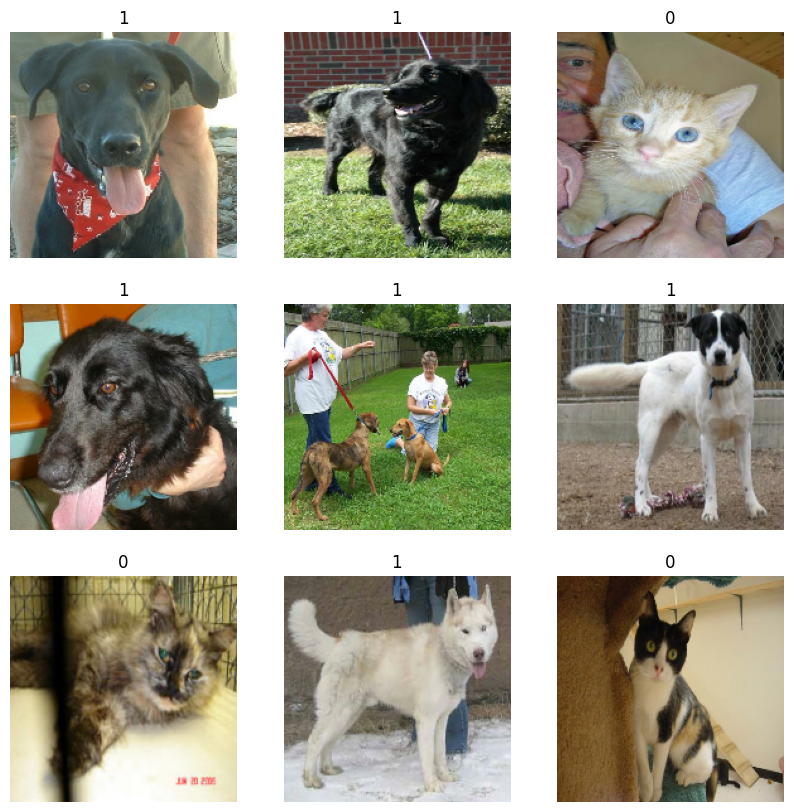

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Görüntü Veri Artırma Kullanımı

Büyük bir görüntü veri kümeniz olmadığında, eğitim görüntülerine rastgele ancak gerçekçi dönüşümler (örneğin rastgele yatay çevirme veya küçük rastgele döndürmeler) uygulayarak yapay olarak örnek çeşitliliği eklemek iyi bir uygulamadır. Bu, modeli eğitim verisinin farklı yönlerine maruz bırakarak aşırı uyumu yavaşlatmaya yardımcı olur.



In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


`data_augmentation`'ı veri kümesindeki ilk birkaç görüntüye tekrar tekrar uygulayarak artırılmış örneklerin neye benzediğini görselleştirelim:

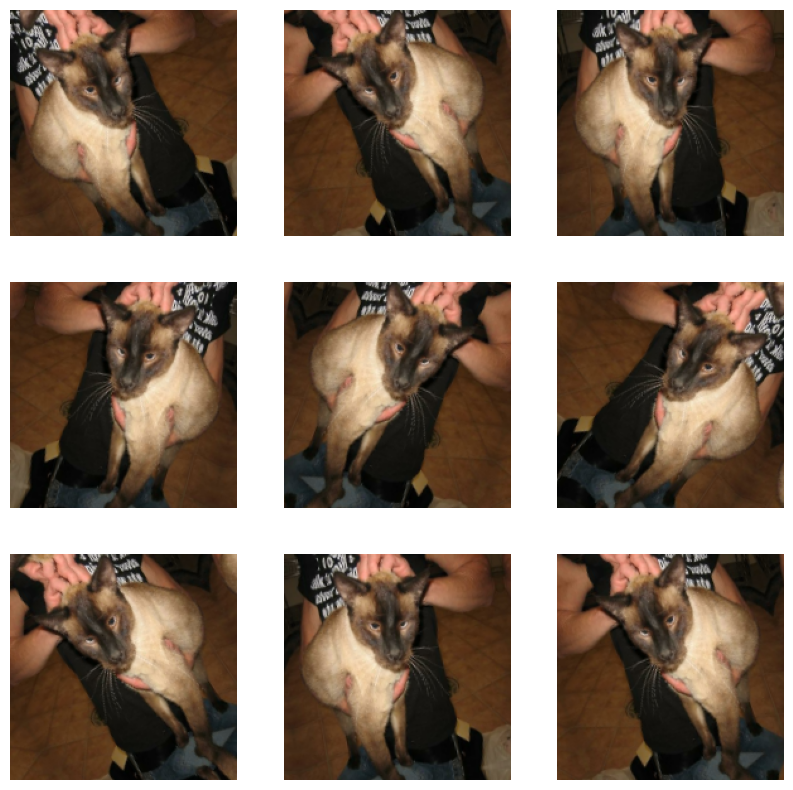

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


## Veriyi Standardize Etme

Görüntülerimiz, veri kümemiz tarafından sürekli `float32` batch'ler olarak verildiği için zaten standart bir boyutta (180x180). Ancak, RGB kanal değerleri `[0, 255]` aralığındadır.
Bu, bir sinir ağı için ideal değildir; genellikle girdi değerlerinizi küçük yapmaya çalışmalısınız. Burada, modelimizin başlangıcında bir `Rescaling` katmanı kullanarak değerleri `[0, 1]` aralığına standardize edeceğiz.

Görüntülerin RGB değerlerini `[0, 255]` aralığından `[0, 1]` gibi daha küçük bir aralığa ölçeklendirmenin (standardize etmenin) birkaç önemli nedeni vardır:

*   **Sinir Ağı Aktivasyon Fonksiyonları:** Sinir ağlarındaki çoğu aktivasyon fonksiyonu (özellikle eski popüler olanlar, örneğin sigmoid ve tanh), girdi değerlerinin küçük ve merkezi olduğu durumlarda en iyi performansı gösterir. Çok büyük girdi değerleri, bu fonksiyonların "doygunluğa" ulaşmasına neden olabilir, bu da gradyanların çok küçülmesine veya yok olmasına yol açarak eğitimin yavaşlamasına veya durmasına neden olabilir (vanishing gradient problemi). Değerleri `[0, 1]` gibi küçük bir aralığa ölçeklemek, aktivasyon fonksiyonlarının daha hassas bölgelerinde çalışmasına yardımcı olur.

*   **Gradyan İnişi Optimizasyonu:** Sinir ağlarını eğitmek için kullanılan gradyan inişi tabanlı optimizasyon algoritmaları (Adam, SGD vb.), girdilerin benzer ölçekte olmasından faydalanır. Eğer girdi özellikleri (bu durumda piksel değerleri) çok farklı ölçeklerdeyse, optimizasyon süreci daha zor ve yavaş olabilir. Örneğin, bir özellik `[0, 1]` aralığında iken diğeri `[0, 255]` aralığında olursa, gradyanlar da farklı büyüklüklerde olacak ve bu da optimize edicinin verimli çalışmasını engelleyebilir. Piksel değerlerini `[0, 1]` gibi standart bir aralığa getirmek, tüm piksellerin benzer ölçekte katkıda bulunmasını sağlar.

*   **Başlangıç Ağırlıkları:** Sinir ağlarının eğitimine genellikle küçük rastgele ağırlıklarla başlanır. Girdi değerleri büyük olduğunda, bu küçük ağırlıklarla çarpıldığında bile ara katmanlardaki değerler çok büyüyebilir. Bu durum, hem gradyan problemlerine yol açabilir hem de modelin başlangıçta kararsız olmasına neden olabilir. Girdi değerlerini küçük tutmak, bu erken aşama kararsızlığını azaltmaya yardımcı olur.

*   **Sayısal Kararlılık:** Kayan noktalı hesaplamalar sırasında çok büyük sayılarla çalışmak, sayısal kararlılık sorunlarına yol açabilir. Değerleri `[0, 1]` aralığına sıkıştırmak, hesaplamaların daha kararlı olmasını sağlar.

## Veriyi ön işlemek için iki seçenek

`data_augmentation` ön işlemcisini kullanabileceğiniz iki yol vardır:

**Seçenek 1: Modelin bir parçası haline getirin**, şöyle:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```
Bu seçenekte, veri artırma işleminiz *cihaz üzerinde*, model yürütülmesinin geri kalanıyla eşzamanlı olarak gerçekleşir, yani GPU hızlandırmasından faydalanacaktır.

Veri artırmanın test zamanında etkin olmadığını unutmayın, bu nedenle girdi örnekleri yalnızca `fit()` sırasında artırılır, `evaluate()` veya `predict()` çağrılırken değil.

Eğer GPU üzerinde eğitim yapıyorsanız, bu iyi bir seçenek olabilir.

**Seçenek 2: Veri kümesine uygulayın**, böylece artırılmış görüntü batch'leri üreten bir veri kümesi elde edersiniz, şöyle:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

Bu seçenekte, veri artırma işleminiz **CPU üzerinde**, eşzamansız olarak gerçekleşir ve modele girmeden önce ara belleğe alınır.

Eğer CPU üzerinde eğitim yapıyorsanız, veri artırmayı eşzamansız ve engellemeyen hale getirdiği için bu daha iyi bir seçenektir.

Bizim durumumuzda, ikinci seçeneği tercih edeceğiz. Hangisini seçeceğinizden emin değilseniz, bu ikinci seçenek (eşzamansız ön işleme) her zaman sağlam bir tercihtir.

## Veri kümesini performans için yapılandırma

Eğitim veri kümemize veri artırma uygulayalım ve G/Ç'nin engellemesini önleyerek diskten veri sağlayabilmemiz için ara belleğe alınmış ön getirme kullandığımızdan emin olalım:

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Model Oluşturma

Xception ağının küçük bir versiyonunu oluşturacağız. Mimarinin optimizasyonu için özel bir çaba göstermedik; en iyi model yapılandırması için sistematik bir arama yapmak isterseniz, [KerasTuner](https://github.com/keras-team/keras-tuner) kullanmayı düşünebilirsiniz.

Şunlara dikkat edin:

*   Modele `data_augmentation` ön işlemcisiyle başlıyoruz, ardından bir `Rescaling` katmanı geliyor.
*   Son sınıflandırma katmanından önce bir `Dropout` katmanı ekliyoruz.

Bu kod bloğu, daha önce tanımlanan sinir ağını eğitmek için kullanılır. İşte önemli kısımları:

1.  `epochs = 25`: Bu, modelin tüm eğitim veri kümesini kaç kez göreceğini (yani kaç eğitim dönemi - epoch) belirler. 25 epoch olarak ayarlanmış. Her epoch'ta model, tüm eğitim verileri üzerinde bir geçiş yapar ve ağırlıklarını günceller.
2.  `callbacks = [...]`: Bu, eğitim sırasında belirli noktalarda çalıştırılacak bir geri çağrı (callback) listesidir. Burada bir `ModelCheckpoint` geri çağrısı tanımlanmış:
    *   `keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")`: Bu geri çağrı, her epoch'un sonunda modelin o anki ağırlıklarını bir dosyaya kaydeder. Dosya adı "save\_at\_" ile başlayacak ve `{epoch}` yerine o epoch'un numarası gelecektir (örn: `save_at_1.keras`, `save_at_2.keras` vb.). Bu, eğitimi yarıda keserseniz veya en iyi performansı veren modeli daha sonra kullanmak isterseniz modelinizi kaydetmenizi sağlar.
3.  `model.compile(...)`: Bu adımda, model eğitim için yapılandırılır. Modelin nasıl öğrenme yapacağı, hataları nasıl ölçeceği ve performansı nasıl değerlendireceği burada belirlenir.
    *   `optimizer=keras.optimizers.Adam(3e-4)`: Optimizasyon algoritmasını belirler. `Adam` popüler ve genellikle etkili bir optimizasyon algoritmasıdır. `3e-4` (yani 0.0003) ise öğrenme oranıdır. Öğrenme oranı, modelin her adımda ağırlıklarını ne kadar güncelleyeceğini kontrol eder.
    *   `loss=keras.losses.BinaryCrossentropy(from_logits=True)`: Modelin tahminlerinin ne kadar hatalı olduğunu ölçmek için kullanılan kayıp fonksiyonunu belirler. `BinaryCrossentropy`, ikili sınıflandırma problemleri (iki sınıf arasındaki ayrım) için yaygın olarak kullanılır. `from_logits=True` parametresi, modelin son katmanının aktivasyon fonksiyonu uygulamadan ham tahminler (logitler) döndürdüğünü belirtir. Kayıp fonksiyonu bu logitleri kullanarak kaybı hesaplar.
    *   `metrics=[keras.metrics.BinaryAccuracy(name="acc")]`: Eğitim ve doğrulama sırasında modelin performansını izlemek için kullanılan metrikleri belirler. `BinaryAccuracy`, ikili sınıflandırmada doğruluğu ölçer (doğru tahminlerin yüzdesi). `name="acc"` metriğe "acc" adını verir.
4.  `model.fit(...)`: Bu fonksiyon, modelin eğitimini başlatır.
    *   `train_ds`: Modelin üzerinde eğitim yapacağı eğitim veri kümesi.
    *   `epochs=epochs`: Yukarıda tanımlanan epoch sayısı kadar eğitim yapılacağını belirtir.
    *   `callbacks=callbacks`: Eğitim sırasında çalışacak geri çağrı listesi.
    *   `validation_data=val_ds`: Her epoch'un sonunda modelin performansının değerlendirileceği doğrulama veri kümesi. Model bu veri kümesinden öğrenmez, sadece performansı ölçülür.

Özetle, bu kod bloğu modeli `Adam` optimizer kullanarak, `BinaryCrossentropy` kaybını minimize edecek şekilde 25 epoch boyunca eğitir. Eğitim sırasında her epoch sonunda model ağırlıkları kaydedilir ve doğrulama veri kümesi üzerinde modelin doğruluğu izlenir.

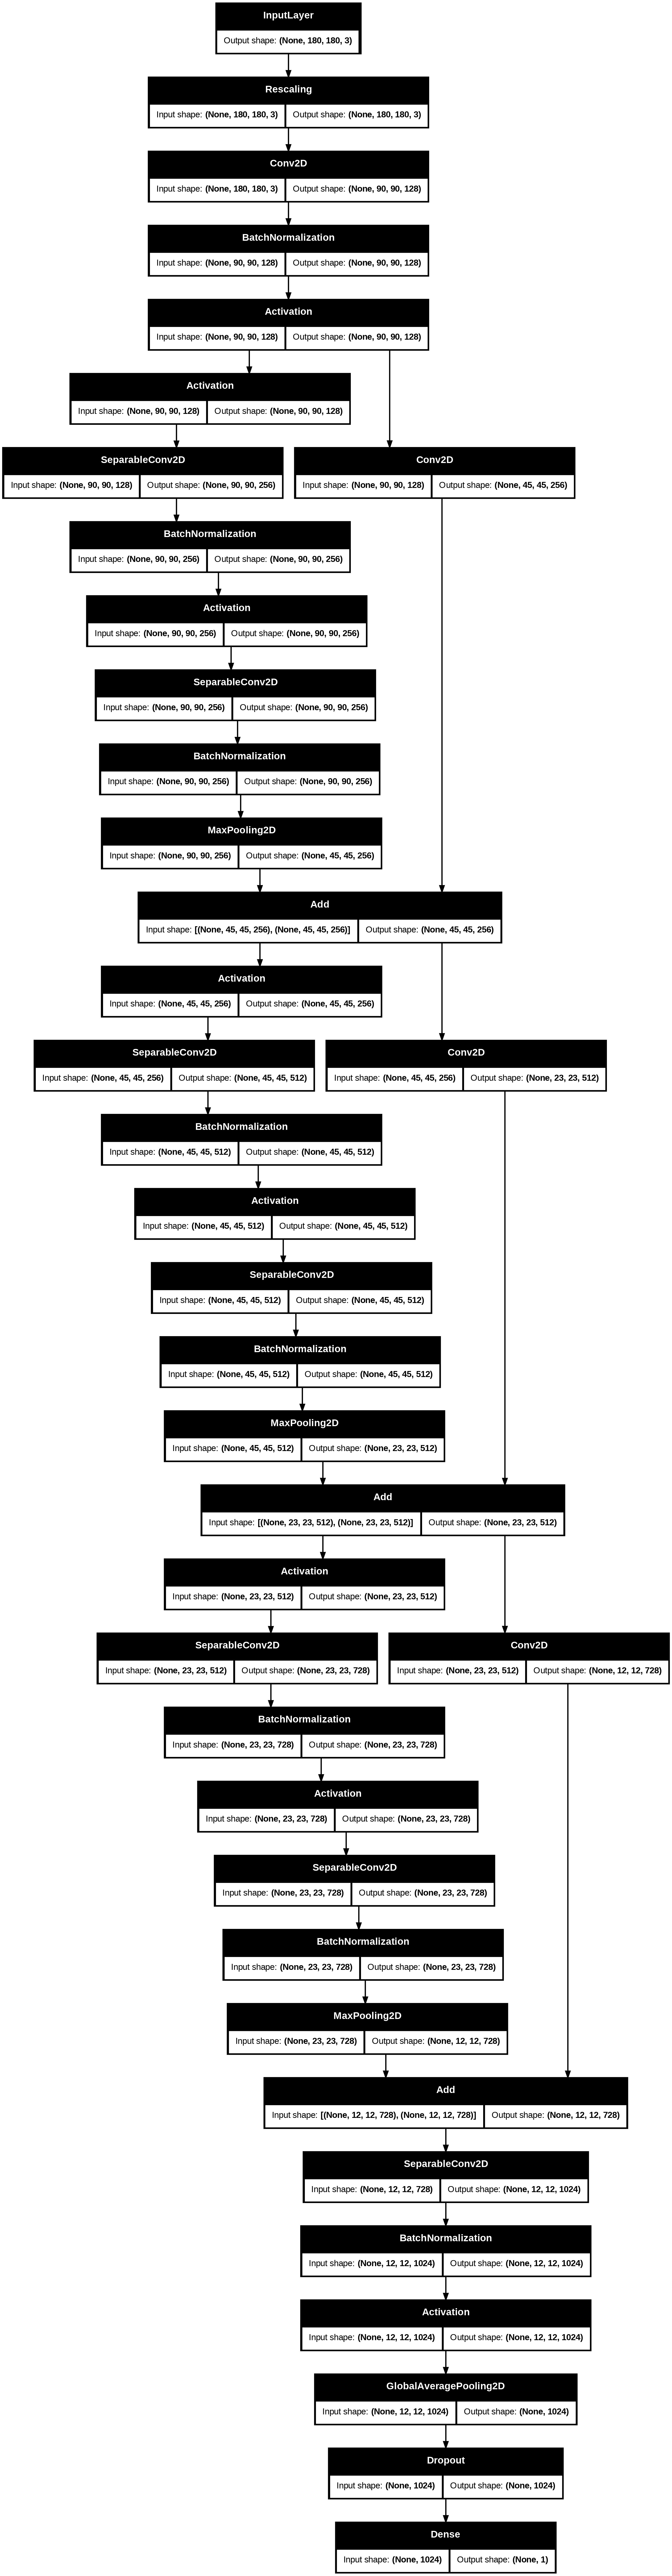

In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - acc: 0.6256 - loss: 0.6414 - val_acc: 0.4957 - val_loss: 0.7000
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - acc: 0.7519 - loss: 0.4848 - val_acc: 0.4957 - val_loss: 0.6943
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - acc: 0.8178 - loss: 0.3874 - val_acc: 0.4957 - val_loss: 0.6912
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - acc: 0.8477 - loss: 0.3258 - val_acc: 0.4957 - val_loss: 0.8811
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - acc: 0.8765 - loss: 0.2803 - val_acc: 0.6149 - val_loss: 0.6755
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - acc: 0.8904 - loss: 0.2530 - val_acc: 0.8832 - val_loss: 0.2618
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - acc: 0.9088 - loss: 0.2102 - val_acc: 0.9161 - val_loss: 0.2146
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - acc: 0.9146 - loss: 0.1977 - val_acc: 0.9180 - val_loss: 0.2157
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/

Tüm veri kümesi üzerinde 25 epoch eğittikten sonra doğruluk oranını >%90'a çıkarıyoruz (pratikte, doğrulama performansı düşmeye başlamadan önce 50+ epoch eğitebilirsiniz).

## Yeni veri üzerinde çıkarım yapma

Veri artırma ve dropout'un çıkarım zamanında aktif olmadığını unutmayın.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
This image is 93.76% cat and 6.24% dog.


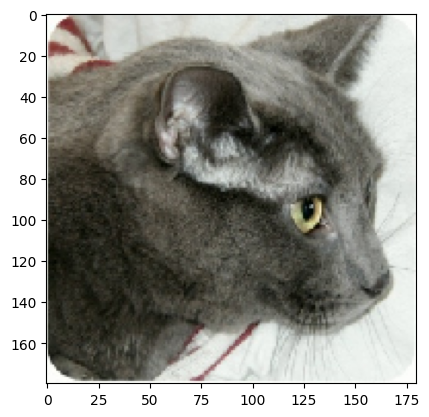

In [ ]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")